In [1]:
import numpy as np
from qiskit import *

# 1. 고급 회로

# 불투명한 게이트

In [2]:
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])

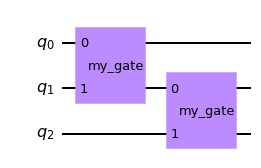

In [3]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw('mpl')

my_gate는 내부의 내용이 보이지 않음. -> 불투명한 게이트

# 합성 게이트들

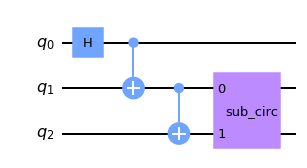

In [4]:
# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u(1, 2, -2, sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw('mpl')

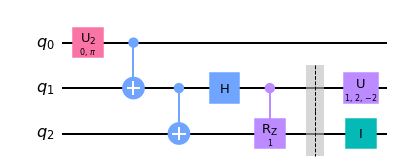

In [5]:
decomposed_circ = circ.decompose() # Does not modify original circuit
decomposed_circ.draw('mpl')

circ.decompose를 쓰면 불투명한 게이트의 내부 게이트를 모두 분해해서 보여줌

# 매개변수를 가진 회로들

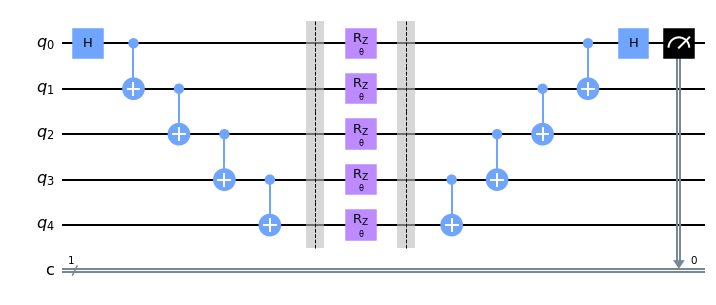

In [6]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

변수 theta를 가진 Rz게이트가 추가되었다. 변수 theta의 값에 따라 Rz(theta)의 값이 달라짐

In [7]:
print(qc.parameters)

ParameterView([Parameter(θ)])


# 값에 매개변수 바인딩하기

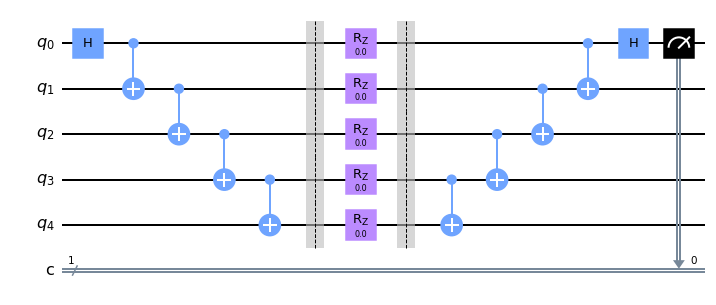

In [8]:
theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]
circuits[i].draw('mpl')

qc.bind_parameters({dic})는 dic 안의 변수 값을 qc 회로에 대입해줌

In [9]:
backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

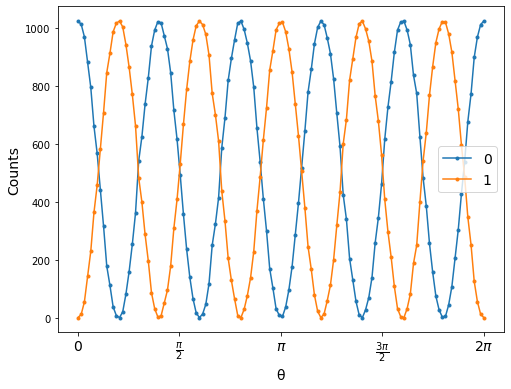

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

# 컴파일 비용 줄이기

In [11]:
import time
from itertools import combinations
from qiskit.compiler import assemble
from qiskit.providers.fake_provider import FakeVigo
start = time.time()
qcs = []

theta_range = np.linspace(0, 2*np.pi, 32)

for n in theta_range:
    qc = QuantumCircuit(5)

    for k in range(8):
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)
        qc.rz(n, range(5))
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)

    qcs.append(qc)

compiled_circuits = transpile(qcs, backend=FakeVigo())
qobj = assemble(compiled_circuits, backend=FakeVigo())

end = time.time()
print('Time compiling over set of bound circuits: ', end-start)

Time compiling over set of bound circuits:  9.951377153396606


In [12]:
start = time.time()
qc = QuantumCircuit(5)
theta = Parameter('theta')

for k in range(8):
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)
    qc.rz(theta, range(5))
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)

transpiled_qc = transpile(qc, backend=FakeVigo())
qobj = assemble([transpiled_qc.bind_parameters({theta: n})
                 for n in theta_range], backend=FakeVigo())
end = time.time()
print('Time compiling over parameterized circuit, then binding: ', end-start)

Time compiling over parameterized circuit, then binding:  1.2047765254974365


# 합성

In [13]:
phi = Parameter('phi')

sub_circ1 = QuantumCircuit(2, name='sc_1')
sub_circ1.rz(phi, 0)
sub_circ1.rx(phi, 1)

sub_circ2 = QuantumCircuit(2, name='sc_2')
sub_circ2.rx(phi, 0)
sub_circ2.rz(phi, 1)

qc = QuantumCircuit(4)
qr = qc.qregs[0]

qc.append(sub_circ1.to_instruction(), [qr[0], qr[1]])
qc.append(sub_circ2.to_instruction(), [qr[0], qr[1]])

qc.append(sub_circ2.to_instruction(), [qr[2], qr[3]])

qc.draw()

# The following raises an error: "QiskitError: 'Name conflict on adding parameter: phi'"
# phi2 = Parameter('phi')
# qc.u3(0.1, phi2, 0.3, 0)

┌────────────┐┌────────────┐
q_0: ┤0           ├┤0           ├
     │  sc_1(phi) ││  sc_2(phi) │
q_1: ┤1           ├┤1           ├
     ├────────────┤└────────────┘
q_2: ┤0           ├──────────────
     │  sc_2(phi) │              
q_3: ┤1           ├──────────────
     └────────────┘

## to_instruction은 sub_circ를 gate로 변환해서, 다른 회로에 삽입할 수 있는 형태로 만들어줌. 삽입은 circ.append(sub_circ,qr[0],[qr[1]])의 형태로 가능.

## qr = qc.qregs는 qc의 register를 만드는 것 같은데.. 이름 q가 어디서 입력되는거지

        ┌────────────────┐
q740_0: ┤0               ├
        │                │
q740_1: ┤1 oracle(theta) ├
        │                │
q740_2: ┤2               ├
        └┬──────────────┬┘
q740_3: ─┤0             ├─
         │              │ 
q740_4: ─┤1 oracle(phi) ├─
         │              │ 
q740_5: ─┤2             ├─
        ┌┴──────────────┴┐
q740_6: ┤0               ├
        │                │
q740_7: ┤1 oracle(gamma) ├
        │                │
q740_8: ┤2               ├
        └────────────────┘


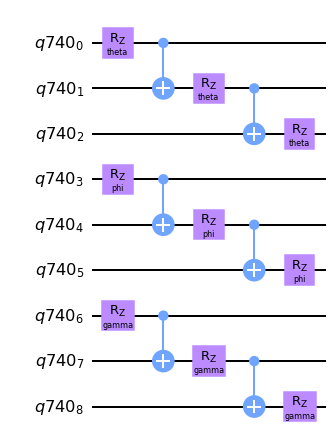

In [14]:
p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])
print(larger_qc.draw())

larger_qc.decompose().draw('mpl')

# 2. 연산자

In [15]:
import numpy as np

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import BasicAer
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import process_fidelity

from qiskit.extensions import RXGate, XGate, CXGate

# 연산자 만들기

In [16]:
XX = Operator([[0, 0, 0, 1], [0, 0, 1, 0], [0, 1, 0, 0], [1, 0, 0, 0]])
XX

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

# 연산자의 특성

In [17]:
XX.data

array([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [18]:
input_dim, output_dim = XX.dim
input_dim, output_dim

(4, 4)

# 입력과 출력의 차원

In [19]:
op = Operator(np.random.rand(2 ** 1, 2 ** 2))
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (2, 2)
Output dimensions: (2,)


In [20]:
op = Operator(np.random.rand(6, 6))
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (6,)
Output dimensions: (6,)


In [21]:
# Force input dimension to be (4,) rather than (2, 2)
op = Operator(np.random.rand(2 ** 1, 2 ** 2), input_dims=[4])
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (4,)
Output dimensions: (2,)


In [22]:
# Specify system is a qubit and qutrit
op = Operator(np.random.rand(6, 6),
              input_dims=[2, 3], output_dims=[2, 3])
print('Input dimensions:', op.input_dims())
print('Output dimensions:', op.output_dims())

Input dimensions: (2, 3)
Output dimensions: (2, 3)


In [23]:
print('Dimension of input system 0:', op.input_dims([0]))
print('Dimension of input system 1:', op.input_dims([1]))

Dimension of input system 0: (2,)
Dimension of input system 1: (3,)


# 클래스를 연산자로 변환하기

In [24]:
# Create an Operator from a Pauli object

pauliXX = Pauli('XX')
Operator(pauliXX)

Operator([[0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [25]:
# Create an Operator for a Gate object
Operator(CXGate())

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [26]:
# Create an operator from a parameterized Gate object
asd = Operator(RXGate(np.pi / 2))
asd

Operator([[0.70710678+0.j        , 0.        -0.70710678j],
          [0.        -0.70710678j, 0.70710678+0.j        ]],
         input_dims=(2,), output_dims=(2,))

In [27]:
# Create an operator from a QuantumCircuit object
circ = QuantumCircuit(10)
circ.h(0)
for j in range(1, 10):
    circ.cx(j-1, j)

# Convert circuit to an operator by implicit unitary simulation
Operator(circ)

Operator([[ 0.70710678+0.j,  0.70710678+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          ...,
          [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.        +0.j,  0.        +0.j,  0.70710678+0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j],
          [ 0.70710678+0.j, -0.70710678+0.j,  0.        +0.j, ...,
            0.        +0.j,  0.        +0.j,  0.        +0.j]],
         input_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2), output_dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))

### 연산자를 행렬로? 나타내주는 것임

# 회로에서 연산자 사용하기

### Unitary 연산자는 append를 사용해서 circ에 바로 넣어줄 수 있음

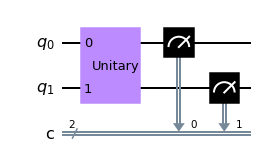

In [28]:
# Create an operator
XX = Operator(Pauli('XX'))

# Add to a circuit
circ = QuantumCircuit(2, 2)
circ.append(XX, [0, 1])
circ.measure([0,1], [0,1])
circ.draw('mpl')

In [29]:
Operator.is_unitary(XX)

True

In [30]:
backend = BasicAer.get_backend('qasm_simulator')
circ = transpile(circ, backend, basis_gates=['u1','u2','u3','cx'])
job = backend.run(circ)
job.result().get_counts(0)

{'11': 1024}

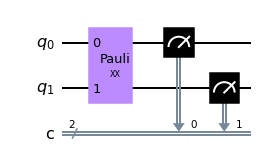

In [31]:
# Add to a circuit
circ2 = QuantumCircuit(2, 2)
circ2.append(Pauli('XX'), [0, 1])
circ2.measure([0,1], [0,1])
circ2.draw('mpl')

# 연산자 결합하기

In [32]:
A = Operator(Pauli('X'))
B = Operator(Pauli('Z'))
A.tensor(B)

Operator([[ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j],
          [ 0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j, -0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [33]:
A = Operator(Pauli('X'))
B = Operator(Pauli('Z'))
A.expand(B)

Operator([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j],
          [ 0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

### 텐서곱은 A.tensor(B) = A * B에서 B는 서브 시스템 0, A는 서브 시스템 1에 해당한다

### 텐서 확장은 순서가 반대라서, A가 서브 시스템 1??? 이거 설명 잘못된 듯

In [34]:
A = Operator(Pauli('X'))
B = Operator(Pauli('Z'))
A.compose(B)

Operator([[ 0.+0.j,  1.+0.j],
          [-1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))

### 행렬곱은 A.compose(B) = [B][A]를 준다.

### front=True를 주면 [A][B]를 준다.

In [35]:
A.compose(B,front=True)

Operator([[ 0.+0.j, -1.+0.j],
          [ 1.+0.j,  0.+0.j]],
         input_dims=(2,), output_dims=(2,))

# 서브시스템 구성

In [36]:
# Compose XZ with an 3-qubit identity operator
op = Operator(np.eye(2 ** 3))
XZ = Operator(Pauli('XZ'))
op.compose(XZ, qargs=[0, 2])

Operator([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  1.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
           -1.+0.j],
          [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j],
          [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
            0.+0.j]],
         input_dims=(2, 2, 2), output_dims=(2, 2, 2))

.....

# 3. 양자 회로를 시각화하기

# 4. 트랜스파일러 패스 및 패스 매니저

# 5. 펄스 게이트들

#### 펄스를 이용해서 정확한 동작 수행 시간을 직접 지정할 수 있음

# 회로 구성하기

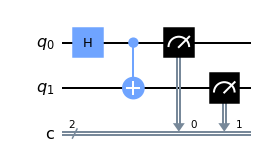

In [146]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(2, 2)
circ.h(0)
circ.cx(0, 1)
circ.measure(0, 0)
circ.measure(1, 1)

circ.draw('mpl')

# 교정(calibration) 구성하기

In [38]:
from qiskit import pulse
from qiskit.pulse.library import Gaussian
from qiskit.providers.fake_provider import FakeValencia

backend = FakeValencia()

with pulse.build(backend, name='hadamard') as h_q0:
    pulse.play(Gaussian(duration=128, amp=0.1, sigma=16), pulse.drive_channel(0))

###### FakeValencia라는 백엔드가 pulse를 지원함

In [39]:
backend.configuration().open_pulse

True

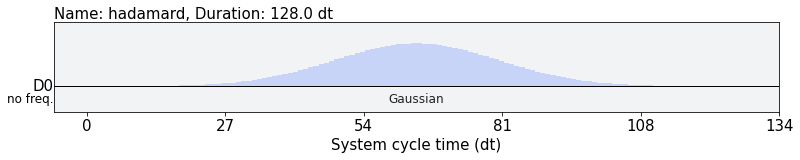

In [40]:
h_q0.draw()

# 회로에 교정을 링크하기

In [41]:
circ.add_calibration('h', [0], h_q0)

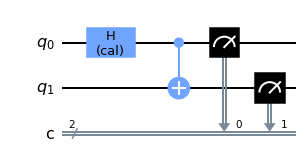

In [42]:
circ.draw('mpl')

['id', 'rz', 'sx', 'x', 'cx', 'reset']


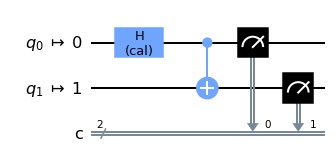

In [43]:
from qiskit import transpile
from qiskit.providers.fake_provider import FakeHanoi

backend = FakeHanoi()

circ = transpile(circ, backend)

print(backend.configuration().basis_gates)
circ.draw('mpl', idle_wires=False)

###### 보정이 추가된 [0]큐빗의 h 게이트가 basis gate로 취급됨. 

###### 보정이 없는 다른 큐빗의 h 게이트는 basis gate로 취급되지 않을 것임.

# 사용자 설정 게이트 + parameter가 추가됨

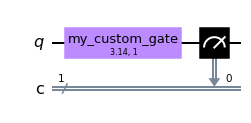

In [151]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

circ = QuantumCircuit(1, 1)
custom_gate = Gate('my_custom_gate', 1, [3.14, 1])
# 3.14 is an arbitrary parameter for demonstration
circ.append(custom_gate, [0])
circ.measure(0, 0)

circ.draw('mpl')

In [162]:
with pulse.build(backend, name='custom') as my_schedule:
    pulse.play(Gaussian(duration=64, amp=0.2, sigma=8), pulse.drive_channel(0))

circ.add_calibration('my_custom_gate', [0], my_schedule,[3.14,1])
#circ.add_calibration(custom_gate, [0], my_schedule)

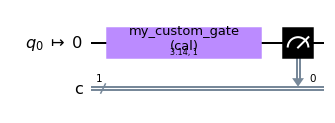

In [163]:
circ = transpile(circ, backend)
circ.draw('mpl', idle_wires=False)

###### my_custom_gate가 정의되지 않은 gate이기 때문에 compile은 못함

In [47]:
circ = QuantumCircuit(2, 2)
circ.append(custom_gate, [1])


from qiskit import QiskitError
try:
    circ = transpile(circ, backend)
except QiskitError as e:
    print(e)

"Cannot unroll the circuit to the given basis, ['id', 'rz', 'sx', 'x', 'cx', 'reset']. Instruction my_custom_gate not found in equivalence library and no rule found to expand."


# 6. 펄스 스케줄 구성하기

#### 펄스 스케줄 - 펄스의 명령 시퀀스를 나타냄

In [48]:
from qiskit import pulse

with pulse.build(name='my_example') as my_program:
    # Add instructions here
    pass

my_program

# 명령어가 없는 빈 스케줄

ScheduleBlock(, name="my_example", transform=AlignLeft())

# 스케줄 명령어

* delay(duration, channel)

* play(pulse, channel)

* set_frequency(frequency, channel)

* shift_phase(phase, channel)

* acquire(duration, channel, mem_slot, reg_slot)

#### 명령어들 모두 channel을 피연산자로 가지고 있음

#### channel - 명령어가 어디에 적용될 것인지를 알려줌

* DriveChannel

* ControlChannel

* MeasureChannel

* AcquireChannel

In [57]:
from qiskit.pulse import DriveChannel

channel = DriveChannel(0)

#### 원래 channel은 backend와는 독립적이지만, backend를 인식하는 상황에서 구현할 수도 있고, 이게 나음

In [50]:
from qiskit.providers.fake_provider import FakeValencia

backend = FakeValencia()

with pulse.build(backend=backend, name='backend_aware') as backend_aware_program:
    channel = pulse.drive_channel(0)
    print(pulse.num_qubits())
    # Raises an error as backend only has 5 qubits
    #pulse.drive_channel(100)

5


# delay 명령어

#### 지정된 시간 간격동안 주어진 채널에 신호를 출력하지 않도록 차단 - 타이밍 조절에 유용

#### delay(duration, channel) 에서 channel에는 모든 채널 입력 가능, duration은 dt의 단위로 정수 값을 가짐

In [55]:
with pulse.build(backend) as delay_5dt:
    pulse.delay(5, channel)

In [56]:
delay_5dt

ScheduleBlock(Delay(5, DriveChannel(0)), name="block6", transform=AlignLeft())

#### 나중에 이 delay_5dt라는 스케줄에 추가된 구성은 5 timestep 뒤에 실행될 것임

# play 명령어

#### 펄스를 실행하는 명령어

In [65]:
with pulse.build() as sched:
    pulse.play(pulse, channel)

TypeError: object of type 'module' has no len()

#### pulse 변수 - 임의의 포락선 펄스

In [67]:
from qiskit.pulse import library

amp = 1
sigma = 10
num_samples = 128

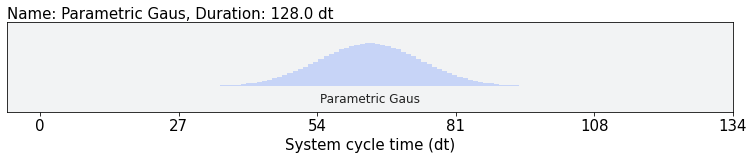

In [74]:
gaus = library.Gaussian(num_samples, amp, sigma,
                              name="Parametric Gaus")
gaus.draw()

In [ ]:
#### Waveform을 통해서 

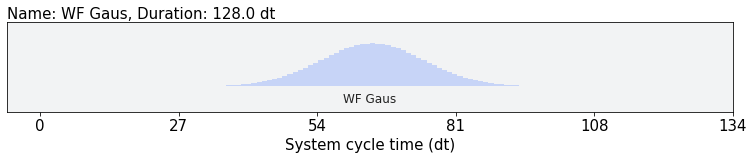

In [71]:
import numpy as np

times = np.arange(num_samples)
gaussian_samples = np.exp(-1/2 *((times - num_samples / 2) ** 2 / sigma**2))

gaus = library.Waveform(gaussian_samples, name="WF Gaus")
gaus.draw()

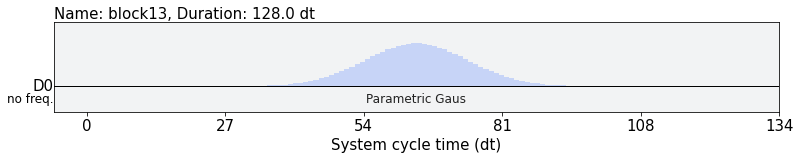

In [80]:
with pulse.build() as schedule:
    pulse.play(gaus, channel)
schedule.draw()

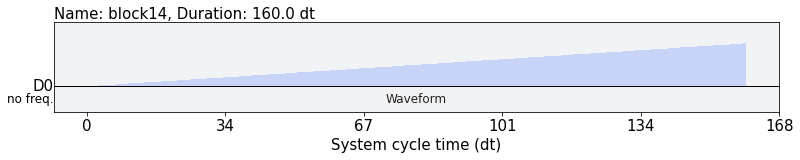

In [81]:
with pulse.build() as schedule:
    pulse.play([0.001*i for i in range(160)], channel)
schedule.draw()

# Set frequency 명령어

In [84]:
with pulse.build(backend) as schedule:
    pulse.set_frequency(4.5e9, channel)
    pulse.play([0.001*i for i in range(160)], channel)


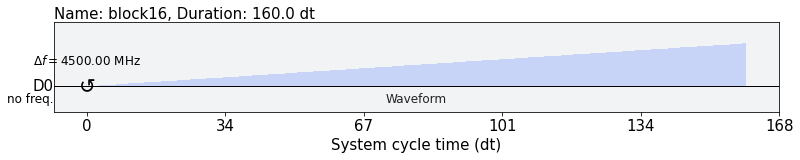

In [85]:
schedule.draw()

# Shift 명령어

In [89]:
with pulse.build(backend) as schedule:
    pulse.set_frequency(4.5e9, channel)
    pulse.play([0.001*i for i in range(160)], channel)
    pulse.shift_phase(np.pi, channel)

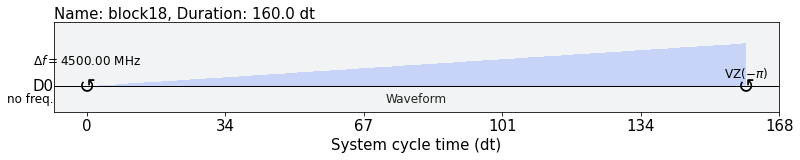

In [90]:
schedule.draw()

# acquire 명령어

In [91]:
from qiskit.pulse import Acquire, AcquireChannel, MemorySlot

with pulse.build(backend) as schedule:
    pulse.acquire(1200, pulse.acquire_channel(0), MemorySlot(0))

# 펄스 빌더

#### 스케줄을 작성하는 데에 있어서 편리한 기능 제공

## 정렬 컨텍스트(Align context)

# Align_left

#### 기본값으로 align_left 되어있응

#### 수행 시간이 다른 두 채널이 있을 때 왼쪽으로 정렬됨

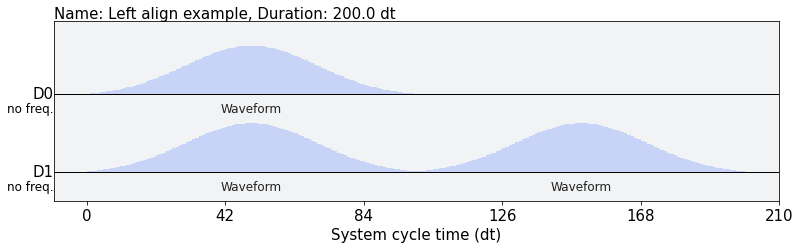

In [96]:
with pulse.build(backend, name='Left align example') as program:
    with pulse.align_left():
        gaussian_pulse = library.gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

# Align_right

#### align_left와 반대. 시간 자유도가 존재하는 스케줄을 최대한 오른쪽으로 붙여놓음

#### as soon as possible  vs  as late as possible

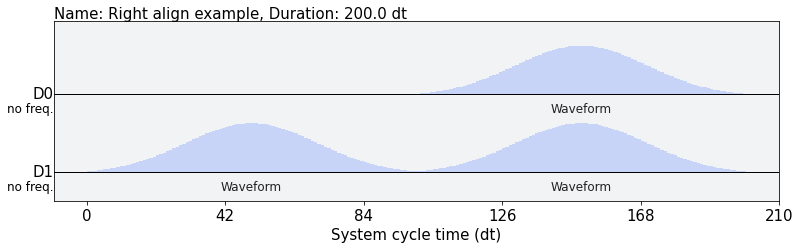

In [97]:
with pulse.build(backend, name='Right align example') as program:
    with pulse.align_right():
        gaussian_pulse = library.gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

# align_equispaced(duration)

# duration 시간 간격동안 실행시키는 것. 각 펄스를 대칭적으로 배치

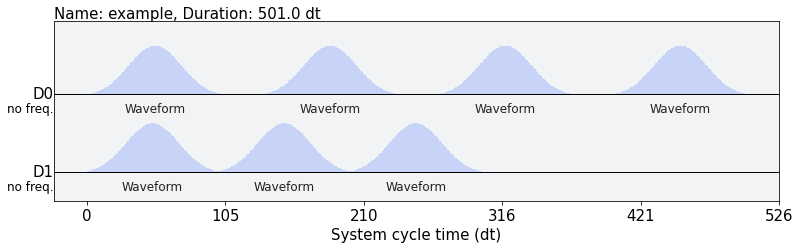

In [138]:
with pulse.build(backend, name='example') as program:
    gaussian_pulse = library.gaussian(100, 0.5, 20)
    with pulse.align_equispaced(500):
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(0))

    pulse.play(gaussian_pulse, pulse.drive_channel(1))
    pulse.play(gaussian_pulse, pulse.drive_channel(1))
    pulse.play(gaussian_pulse, pulse.drive_channel(1))


program.draw()

# set_sequential 

#### 병렬적으로 배치하지 않고, 이전에 넣어준 지시사항이 끝나는 시간에 새로운 걸 넣어줌

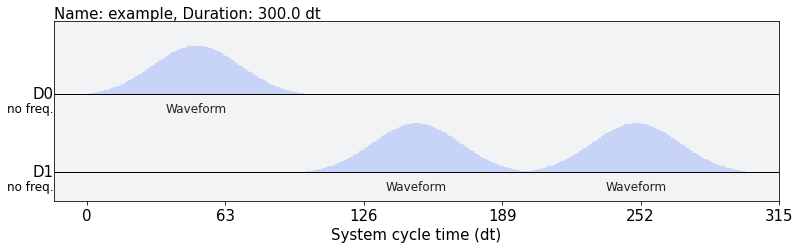

In [140]:
with pulse.build(backend, name='example') as program:
    with pulse.align_sequential():
        gaussian_pulse = library.gaussian(100, 0.5, 20)
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))
        pulse.play(gaussian_pulse, pulse.drive_channel(1))

program.draw()

# offset

#### phase_offset 과 frequency_offset

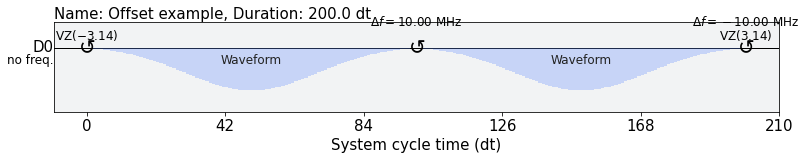

In [142]:
with pulse.build(backend, name='Offset example') as program:
    with pulse.phase_offset(3.14, pulse.drive_channel(0)):
        pulse.play(gaussian_pulse, pulse.drive_channel(0))
        with pulse.frequency_offset(10e6, pulse.drive_channel(0)):
            pulse.play(gaussian_pulse, pulse.drive_channel(0))

program.draw()